In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
import re
import requests
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import f_regression, RFE, SelectKBest
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

In [20]:
df_preprocesamiento = pd.read_csv("data/dataset_preprocesamiento.csv")

## Fase 2

### Feature Engineering

#### Creación de variables: agregaciones temporales (promedios móviles) y variables lag

In [21]:
# ycol = 'Frio' 
# y_obs = df_preprocesamiento[ycol].shift(1)

# # Lags (ejemplos: 1, 7 y 30)
# for k in [1, 7, 30]:
#     df_preprocesamiento[f'{ycol}_lag{k}'] = df_preprocesamiento[ycol].shift(k)

# # Promedios móviles
# for w in [3, 7, 14, 30]:
#     df_preprocesamiento[f'{ycol}_ma{w}'] = y_obs.rolling(window=w, min_periods=1).mean()

#### Creación de variables: dia semana, mes año y fin de semana

In [22]:
df_preprocesamiento['fecha'] = pd.to_datetime(
    df_preprocesamiento['dia'],
    format='%Y-%m-%d',
    errors='coerce'
)

# Día de la semana: 0=Lun ... 6=Dom  (periodo=7)
dow = df_preprocesamiento['fecha'].dt.dayofweek
df_preprocesamiento['dow_sin'] = np.sin(2*np.pi * dow / 7)
df_preprocesamiento['dow_cos'] = np.cos(2*np.pi * dow / 7)

# Mes: 1..12  -> usar índice 0..11 (periodo=12)
m  = df_preprocesamiento['fecha'].dt.month
m0 = (m - 1)  # 0..11
df_preprocesamiento['mes_sin'] = np.sin(2*np.pi * m0 / 12)
df_preprocesamiento['mes_cos'] = np.cos(2*np.pi * m0 / 12)

# Fin de semana: binaario
df_preprocesamiento['dia_semana']   = df_preprocesamiento['fecha'].dt.dayofweek
df_preprocesamiento['fin_de_semana'] = df_preprocesamiento['dia_semana'].isin([5, 6]).astype(int)
df_preprocesamiento.drop(columns=['dia_semana'], inplace=True)

#### Creación de variables: ratios entre consumos de diferentes áreas e interacciones entre variables principales

In [23]:
# Interacciones entre variables principales 
# Elegimos automáticamente las TOP 5 más correlacionadas con el objetivo (en valor absoluto)
num = df_preprocesamiento.select_dtypes(include=[np.number]).copy()
base_corr = y_obs if y_obs.notna().any() else df_preprocesamiento[ycol]
candidatas = [c for c in num.columns if c != ycol and num[c].notna().any()]
top5 = (
    num[candidatas].corrwith(base_corr)
    .abs()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

# a) Productos cruzados entre las TOP
for a, b in combinations(top5, 2):
    df_preprocesamiento[f'{a}x{b}'] = df_preprocesamiento[a] * df_preprocesamiento[b]

# b) Interacciones con señales cíclicas y fines de semana (si existen)
for cyc in ['dow_sin', 'dow_cos', 'mes_sin', 'mes_cos']:
    if cyc in df_preprocesamiento.columns:
        for c in top5:
            df_preprocesamiento[f'{c}_x_{cyc}'] = df_preprocesamiento[c] * df_preprocesamiento[cyc]

if 'fin_de_semana' in df_preprocesamiento.columns:
    for c in top5:
        df_preprocesamiento[f'{c}_x_finde'] = df_preprocesamiento[c] * df_preprocesamiento['fin_de_semana']

In [24]:
# Definición de áreas
AREAS = {
    "Elaboración": r"Elab|Elabor|Coci|Cocina|Mosto|Lauter|Macer|Paste",
    "Envasado":    r"Envas|Llen|Linea|L[2345]\b",
    "Bodega":      r"Bodega|Bodeg",
    "Servicios":   r"Servicios|Vapor|Gas|Agua|Aire|Caldera|Compres|Chiller|Sala",
    "Sala_Maq":    r"Sala.*Maq",
}

# --- Helper: división segura ---
def safe_div(a, b):
    return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=(b != 0))

# Detectar columnas por área (case-insensitive) entre numéricas
num_cols = df_preprocesamiento.select_dtypes(include=[np.number]).columns
area_cols = {}
for area, pat in AREAS.items():
    regex = re.compile(pat, flags=re.IGNORECASE)
    cols = [c for c in num_cols if regex.search(c)]
    area_cols[area] = cols

# Sumar consumo por área (por fila)
area_sum = {}
for area, cols in area_cols.items():
    if cols:  # si hay columnas que matchean
        df_preprocesamiento[f'{area}_sum'] = df_preprocesamiento[cols].sum(axis=1, skipna=True)
        area_sum[area] = df_preprocesamiento[f'{area}_sum']
    else:
        # si no hay columnas, creamos sum=0 para mantener consistencia
        df_preprocesamiento[f'{area}_sum'] = 0.0
        area_sum[area] = df_preprocesamiento[f'{area}_sum']

# Total seleccionado y participaciones 
areas_presentes = list(area_sum.keys())
total_sel = sum(area_sum[a] for a in areas_presentes)
df_preprocesamiento['Consumo_Total_Areas'] = total_sel

for a in areas_presentes:
    df_preprocesamiento[f'{a}_share'] = safe_div(df_preprocesamiento[f'{a}_sum'], df_preprocesamiento['Consumo_Total_Areas'])  # entre 0 y 1

# Ratios entre áreas (parejas) 
for a, b in combinations(areas_presentes, 2):
    df_preprocesamiento[f'ratio_{a}_sobre_{b}'] = safe_div(df_preprocesamiento[f'{a}_sum'], df_preprocesamiento[f'{b}_sum'])
    df_preprocesamiento[f'ratio_{b}_sobre_{a}'] = safe_div(df_preprocesamiento[f'{b}_sum'], df_preprocesamiento[f'{a}_sum'])

# Limpieza de infinitos/NaN residuales
df_preprocesamiento = df_preprocesamiento.replace([np.inf, -np.inf], np.nan)

#### Creación de variables extras: estacionalidad y datos metereológicos

In [25]:
# Estaciones del año
m = df_preprocesamiento['fecha'].dt.month

# Índice de estación 0..3: Inv=0, Prim=1, Ver=2, Oto=3
est_idx = np.select(
    [m.isin([12, 1, 2]), m.isin([3, 4, 5]), m.isin([6, 7, 8]), m.isin([9, 10, 11])],
    [0, 1, 2, 3],
    default=np.nan
)

# Estacionalidad cíclica (periodo=4 estaciones)
df_preprocesamiento['estacion_sin'] = np.sin(2*np.pi * est_idx / 4)
df_preprocesamiento['estacion_cos'] = np.cos(2*np.pi * est_idx / 4)

# Datos metereológicos
start_date = df_preprocesamiento["fecha"].min().date().isoformat()
end_date   = df_preprocesamiento["fecha"].max().date().isoformat()

# Open-Meteo (horaria) Tecate
lat, lon = 32.56717, -116.62509 # Tecate, BC (MX)
url = (
    "https://archive-api.open-meteo.com/v1/archive"
    f"?latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    "&daily=temperature_2m_mean"
    "&timezone=auto"
)

data = requests.get(url, timeout=60).json()
wx_d = pd.DataFrame({
    "fecha": pd.to_datetime(data["daily"]["time"]),
    "t2m_mean_C": data["daily"]["temperature_2m_mean"],
})

# Merge
df_preprocesamiento = df_preprocesamiento.merge(wx_d, on="fecha", how="left")

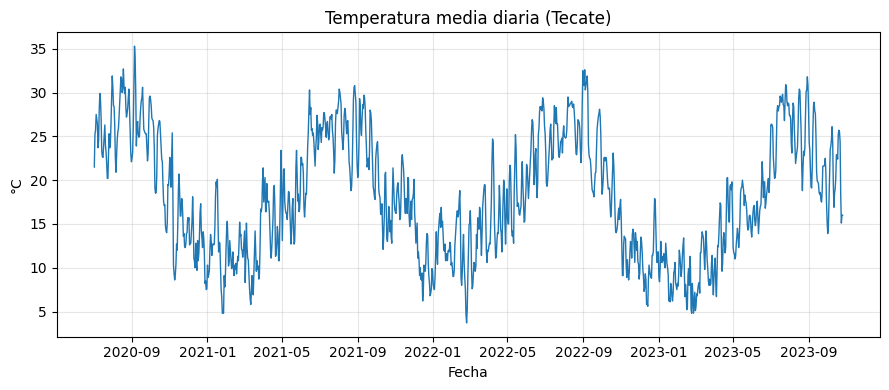

In [26]:
plt.figure(figsize=(9,4))
plt.plot(df_preprocesamiento["fecha"], df_preprocesamiento["t2m_mean_C"], linewidth=1)
plt.title("Temperatura media diaria (Tecate)")
plt.xlabel("Fecha")
plt.ylabel("°C")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [27]:
columnas_con_nulos = df_preprocesamiento.isnull().sum()[df_preprocesamiento.isnull().sum() > 0].index.tolist()
df_preprocesamiento[columnas_con_nulos] = df_preprocesamiento[columnas_con_nulos].fillna(0)

### Selección de variables

In [43]:
# ---------- preparar X, y ----------
df = df_preprocesamiento.copy()
target_col = "Frio"  
X = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors="ignore")
y = df[target_col]

k = 30 # número de features a seleccionar

#### Selección mediante RFE, Random Forest, LASSO y Secuencial hacia adelante (ejecuciones muuuy largas)

In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X, y)
perm = permutation_importance(rf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
features_rf = perm_imp.head(k).index.tolist()

df_perm = pd.concat([df_preprocesamiento.loc[:, features_rf], df_preprocesamiento.loc[:, [target_col]]], axis=1)

In [ ]:
# Importancia de variables con Random Forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(estimator=rf, step=1, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
rfecv.fit(X, y)

ranking = pd.Series(rfecv.ranking_, index=X.columns).sort_values()
features_rfecv = ranking.index[:k].tolist()
df_rfecv = pd.concat([df_preprocesamiento.loc[:, features_rfecv], df_preprocesamiento.loc[:, [target_col]]], axis=1)

In [ ]:
# LASSO
scaler = StandardScaler()
X_lasso = scaler.fit_transform(X)

lasso = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1).fit(X_lasso, y)

coef_abs = pd.Series(lasso.coef_, index=X_lasso.columns).abs()
features_lasso = coef_abs.sort_values(ascending=False).head(k).index.tolist()

df_lasso = df_preprocesamiento.loc[:, features_lasso + ['Frio']]

In [ ]:
# Método de Sequencial Feature Selector (SFS)
modelo = GradientBoostingRegressor(random_state=42)
sfs = SequentialFeatureSelector(modelo, n_features_to_select=k, direction='forward', scoring='neg_mean_absolute_error', n_jobs=-1)
sfs.fit(X, y)

features_seleccionadas = X.columns[sfs.get_support()]
df_sequencial = df_preprocesamiento[features_seleccionadas.tolist() + ['Frio']]

#### Selección mediante métodos de filtro: varianza y f-test

In [ ]:
# Método de la varianza
scaler = MinMaxScaler()
X_var = scaler.fit_transform(X)

var_values = np.var(X_var, axis=0)
var_series = pd.Series(var_values, index=X_var.columns)

variance_features = var_series.sort_values(ascending=False).head(k).index

X_variance_filtrado = X_var[variance_features]
df_varianza_filtrado = pd.concat([X_variance_filtrado, y], axis=1)

# Método f-test (SelectKBest con f_regression)
skb = SelectKBest(score_func=f_regression, k=k)
skb.fit(X, y)

f_features_seleccionadas = X.columns[skb.get_support()]

f_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': skb.scores_,
    'p_value': skb.pvalues_
}).sort_values(by='f_score', ascending=False)

top_features = f_scores.head(k)['feature'].tolist()
df_fscore = pd.concat([df_preprocesamiento.loc[:, top_features], df_preprocesamiento.loc[:, [target_col]]], axis=1)
df_fscore['Frio'] = df_preprocesamiento['Frio']

#### Selección final de features